In [1]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html


In [2]:
import torch
import torch.nn.functional as F
from torch.nn import ReLU, Linear, Module
from torch_geometric.nn import SAGEConv, Sequential
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures


class GraphSAGE(Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        channels = [num_features] + hidden_channels
        convs = []
        for i in range(len(channels) - 1):
            convs.append((
                SAGEConv(channels[i], channels[i + 1]),
                "x, edge_index -> x"
            ))
            convs.append(ReLU(inplace=True))
        convs = convs[:-1]
        self.convs = Sequential("x, edge_index", convs)
        self.linear = Linear(channels[-1], num_classes)
        
    def forward(self, x, edge_index):
        x = self.convs(x, edge_index)
        x = F.dropout(x, p=0.5)
        return self.linear(x)

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

net = GraphSAGE(data.num_features, [256, 64], dataset.num_classes)
print(net)

GraphSAGE(
  (convs): Sequential(
    (0): SAGEConv(1433, 256)
    (1): ReLU(inplace=True)
    (2): SAGEConv(256, 64)
  )
  (linear): Linear(in_features=64, out_features=7, bias=True)
)


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
data.to(device)

criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4) 

for epoch in range(200):
    net.train()
    optimizer.zero_grad() 
    out = net(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask]) 
    loss.backward() 
    optimizer.step() 
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1} Loss {loss}")

Epoch 10 Loss 0.5453739166259766
Epoch 20 Loss 0.012692563235759735
Epoch 30 Loss 0.028224514797329903
Epoch 40 Loss 0.025541456416249275
Epoch 50 Loss 0.019155846908688545
Epoch 60 Loss 0.023301471024751663
Epoch 70 Loss 0.02112516388297081
Epoch 80 Loss 0.020907828584313393
Epoch 90 Loss 0.01925707422196865
Epoch 100 Loss 0.016944391652941704
Epoch 110 Loss 0.018443891778588295
Epoch 120 Loss 0.019670037552714348
Epoch 130 Loss 0.014160421676933765
Epoch 140 Loss 0.018224650993943214
Epoch 150 Loss 0.016735512763261795
Epoch 160 Loss 0.01917252689599991
Epoch 170 Loss 0.01293892040848732
Epoch 180 Loss 0.013179763220250607
Epoch 190 Loss 0.014889326877892017
Epoch 200 Loss 0.01365236472338438


Test Accuracy 0.756


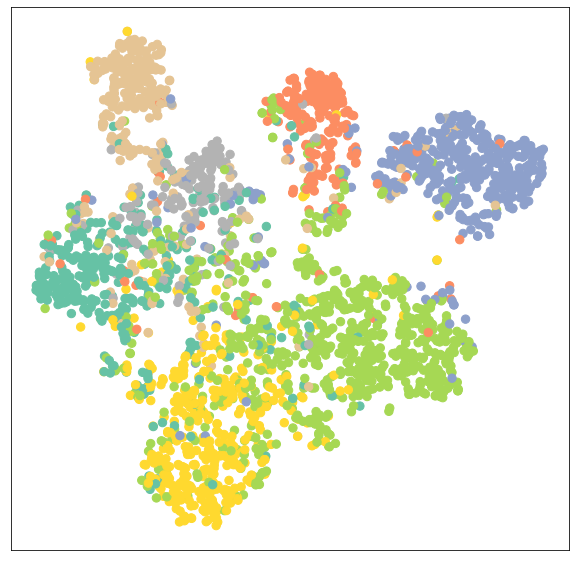

In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

net.eval()
out = net(data.x, data.edge_index)
    
pred = out.argmax(dim=1) 
test_correct = pred[data.test_mask] == data.y[data.test_mask]
test_acc = int(test_correct.sum()) / int(data.test_mask.sum())

print("Test Accuracy", test_acc)

z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])

plt.scatter(z[:, 0], z[:, 1], s=70, c=data.y.cpu(), cmap="Set2")
plt.show()